# Cointegration Pairs Trading

## Goal
Build a **research-grade** (but notebook-friendly) pipeline for **cointegration-based pairs trading**:

1. Load and clean price data
2. Select candidate pairs (Engle–Granger cointegration)
3. Build a spread model + z-score signal
4. Backtest with transaction costs + risk controls
5. Evaluate out-of-sample via walk-forward splits


> Notes:
> - If internet is available, we’ll use `yfinance` for data.
> - If not, the notebook falls back to a synthetic dataset so everything still runs end-to-end.


In [ ]:
from __future__ import annotations

import math
import warnings
from dataclasses import dataclass, replace
from typing import Dict, Iterable, List, Optional, Sequence, Tuple

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 50)

SEED = 42
rng = np.random.default_rng(SEED)

print("Ready.")


Ready.


In [ ]:
import importlib
import sys
import subprocess


def _ensure_package(pkg: str) -> None:
    try:
        importlib.import_module(pkg)
    except Exception:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])


_ensure_package("statsmodels")

try:
    import yfinance as yf  
except Exception:
    yf = None

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

print("Deps ready.")


Deps ready.


## Configuration
We’ll keep the pipeline configurable (tickers, dates, train/test windows, trading rules).

In [ ]:
@dataclass(frozen=True)
class ResearchConfig:
    tickers: Tuple[str, ...] = (
        "MSFT", "AAPL", "GOOGL", "AMZN", "META", "NVDA", "TSLA", "JPM", "BAC", "XOM", "CVX", "KO", "PEP", "WMT"
    )
    start: str = "2020-12-01"
    end: str = "2025-12-01"

    train_days: int = 252 * 2  # ~2 years of training
    test_days: int = 63    # ~3 months of testing

    use_log_prices: bool = True

    # Pair selection
    max_pairs_to_test: int = 60  # cap compute
    coint_pvalue_cutoff: float = 0.05
    min_half_life_days: float = 5.0
    max_half_life_days: float = 90.0

    # Trading rule
    z_lookback: int = 60
    entry_z: float = 2.5
    exit_z: float = 1.0
    stop_z: float = 4.0

    # Risk / sizing
    gross_leverage: float = 1.0        # gross exposure / equity
    max_position_per_leg: float = 0.6  # cap per leg

    # Costs
    cost_bps_per_turnover: float = 2.0  # 2 bps per $ traded (very mild)


cfg = ResearchConfig()
cfg


ResearchConfig(tickers=('MSFT', 'AAPL', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'JPM', 'BAC', 'XOM', 'CVX', 'KO', 'PEP', 'WMT'), start='2020-12-01', end='2025-12-01', train_days=504, test_days=63, use_log_prices=True, max_pairs_to_test=60, coint_pvalue_cutoff=0.05, min_half_life_days=5.0, max_half_life_days=90.0, z_lookback=60, entry_z=2.5, exit_z=1.0, stop_z=4.0, gross_leverage=1.0, max_position_per_leg=0.6, cost_bps_per_turnover=2.0)

## Utilities
Helper functions for returns, drawdowns, and performance metrics.

In [4]:
def to_returns(prices: pd.DataFrame) -> pd.DataFrame:
    rets = prices.pct_change()
    return rets.replace([np.inf, -np.inf], np.nan)


def annualize_return(daily_returns: pd.Series, periods_per_year: int = 252) -> float:
    daily_returns = daily_returns.dropna()
    if len(daily_returns) == 0:
        return np.nan
    growth = (1.0 + daily_returns).prod()
    years = len(daily_returns) / periods_per_year
    return float(growth ** (1.0 / years) - 1.0) if years > 0 else np.nan


def annualize_vol(daily_returns: pd.Series, periods_per_year: int = 252) -> float:
    daily_returns = daily_returns.dropna()
    if len(daily_returns) == 0:
        return np.nan
    return float(daily_returns.std(ddof=0) * math.sqrt(periods_per_year))


def sharpe_ratio(daily_returns: pd.Series, rf_annual: float = 0.0, periods_per_year: int = 252) -> float:
    daily_returns = daily_returns.dropna()
    if len(daily_returns) == 0:
        return np.nan
    rf_daily = (1.0 + rf_annual) ** (1.0 / periods_per_year) - 1.0
    excess = daily_returns - rf_daily
    vol = excess.std(ddof=0)
    return float((excess.mean() / vol) * math.sqrt(periods_per_year)) if vol > 0 else np.nan


def max_drawdown(equity_curve: pd.Series) -> float:
    equity_curve = equity_curve.dropna()
    if len(equity_curve) == 0:
        return np.nan
    peak = equity_curve.cummax()
    dd = equity_curve / peak - 1.0
    return float(dd.min())


def summarize_performance(daily_returns: pd.Series) -> pd.Series:
    daily_returns = daily_returns.dropna()
    equity = (1.0 + daily_returns).cumprod()
    return pd.Series(
        {
            "CAGR": annualize_return(daily_returns),
            "AnnVol": annualize_vol(daily_returns),
            "Sharpe": sharpe_ratio(daily_returns),
            "MaxDD": max_drawdown(equity),
            "TotalReturn": float(equity.iloc[-1] - 1.0) if len(equity) else np.nan,
            "Days": int(len(daily_returns)),
        }
    )


## Data
We’ll load adjusted close prices for a small universe. If `yfinance` is unavailable (or internet is blocked), we generate a synthetic universe with a few cointegrated relationships so the rest of the notebook still demonstrates the full pipeline.

In [5]:
def _synthetic_prices(
    tickers: Sequence[str],
    n_days: int = 252 * 1,
    start: str = "2024-12-01",
    seed: int = 42,
) -> pd.DataFrame:
    r = np.random.default_rng(seed)
    idx = pd.bdate_range(start=start, periods=n_days)

    # Base random walks
    base = pd.DataFrame(index=idx)
    for t in tickers:
        eps = r.normal(0, 0.01, size=n_days)
        base[t] = 100.0 * np.exp(np.cumsum(eps))

    # Inject a few cointegrated relationships by construction
    if len(tickers) >= 4:
        a, b, c, d = tickers[0], tickers[1], tickers[2], tickers[3]
        noise1 = r.normal(0, 0.5, size=n_days)
        noise2 = r.normal(0, 0.7, size=n_days)
        base[b] = 1.2 * base[a] + noise1
        base[d] = 0.8 * base[c] + noise2

    base = base.clip(lower=1.0)
    return base


def load_prices(cfg: ResearchConfig) -> pd.DataFrame:
    tickers = list(cfg.tickers)

    # Ensure synthetic data has enough history for walk-forward
    min_synth_days = int(cfg.train_days + cfg.test_days + 50)

    if yf is None:
        print("yfinance not available; using synthetic prices.")
        return _synthetic_prices(tickers, n_days=min_synth_days, start=cfg.start)

    try:
        df = yf.download(tickers, start=cfg.start, end=cfg.end, auto_adjust=True, progress=False)
        # yfinance returns multi-index columns when multiple tickers
        if isinstance(df.columns, pd.MultiIndex):
            # Prefer Close if present, otherwise Adj Close
            close_level = "Close" if "Close" in df.columns.get_level_values(0) else "Adj Close"
            prices = df[close_level].copy()
        else:
            # Single ticker case
            prices = df[["Close"]].rename(columns={"Close": tickers[0]})

        prices = prices.dropna(how="all")
        prices = prices.ffill().dropna()
        if prices.shape[0] < min_synth_days:
            print("Not enough downloaded history; using synthetic prices.")
            return _synthetic_prices(tickers, n_days=min_synth_days, start=cfg.start)

        return prices
    except Exception as e:
        print(f"Data download failed ({type(e).__name__}: {e}); using synthetic prices.")
        return _synthetic_prices(tickers, n_days=min_synth_days, start=cfg.start)


prices = load_prices(cfg)
prices.tail()


Ticker,AAPL,AMZN,BAC,CVX,GOOGL,JPM,KO,META,MSFT,NVDA,PEP,TSLA,WMT,XOM
Date,,,,,,,,,,,,,,
2025-11-21,271.489990,220.690002,51.293442,149.979996,299.464111,298.019989,72.441185,593.765747,472.119995,178.870041,144.912613,391.089996,105.105743,117.080002
2025-11-24,275.920013,226.279999,51.661530,149.750000,318.371735,298.000000,72.083694,612.550415,474.000000,182.539841,144.090652,417.779999,103.848305,115.970001
2025-11-25,276.970001,229.669998,52.208683,148.529999,323.228577,303.000000,72.103561,635.701477,476.989990,177.810104,144.694748,419.399994,106.782326,114.510002
2025-11-26,277.549988,229.160004,52.716049,149.509995,319.740875,307.640015,72.371674,633.093628,485.500000,180.249954,146.546631,426.579987,108.878059,114.769997
2025-11-28,278.850006,233.220001,53.372639,151.130005,319.970703,313.079987,72.610001,647.421997,492.010010,176.990143,147.299271,430.170013,110.285194,115.919998


## Pair Selection (Cointegration)
We’ll search over candidate ticker pairs and select those with statistically significant cointegration (Engle–Granger). For each candidate pair, we estimate a hedge ratio via OLS and define the spread as:

$$ s_t = y_t - \beta x_t $$

A mean-reverting spread is the core assumption behind pairs trading.

In [6]:
from itertools import combinations


def _ols_beta(y: pd.Series, x: pd.Series) -> float:
    df = pd.concat([y, x], axis=1).dropna()
    if df.shape[0] < 30:
        return np.nan
    yv = df.iloc[:, 0]
    xv = df.iloc[:, 1]
    X = sm.add_constant(xv.values)
    model = sm.OLS(yv.values, X).fit()
    return float(model.params[1])


def _coint_pvalue(y: pd.Series, x: pd.Series) -> float:
    df = pd.concat([y, x], axis=1).dropna()
    if df.shape[0] < 60:
        return np.nan
    stat, pvalue, _ = coint(df.iloc[:, 0].values, df.iloc[:, 1].values)
    return float(pvalue)


def estimate_half_life(spread: pd.Series) -> float:
    """Estimate mean-reversion half-life (days) via AR(1) on spread.

    Model: Δs_t = a + b s_{t-1} + ε_t
    Half-life = -ln(2) / b if b < 0.
    """
    s = spread.dropna()
    if len(s) < 90:
        return np.nan

    ds = s.diff().dropna()
    lag = s.shift(1).reindex(ds.index)

    df = pd.concat([ds, lag], axis=1).dropna()
    if df.shape[0] < 60:
        return np.nan

    y = df.iloc[:, 0].values
    x = df.iloc[:, 1].values
    X = sm.add_constant(x)
    res = sm.OLS(y, X).fit()
    b = float(res.params[1])

    if b >= 0:
        return np.nan
    return float(-math.log(2.0) / b)


def rank_pairs_by_cointegration(
    prices: pd.DataFrame,
    tickers: Sequence[str],
    max_pairs: int = 100,
    use_log_prices: bool = True,
) -> pd.DataFrame:
    """Return candidate pairs with p-values, hedge ratios, and half-life.

    Intended to run on TRAIN data only.
    """
    tickers = [t for t in tickers if t in prices.columns]
    px = prices[tickers].dropna(how="all").ffill().dropna()

    if use_log_prices:
        px = np.log(px.clip(lower=1e-6))

    pairs = list(combinations(tickers, 2))

    # Heuristic pre-filter: prioritize highly correlated pairs (using log returns)
    rets = px.diff().dropna(how="any")
    corr = rets.corr()

    scored: List[Tuple[str, str, float]] = []
    for a, b in pairs:
        c = float(corr.loc[a, b])
        scored.append((a, b, abs(c)))
    scored.sort(key=lambda t: t[2], reverse=True)
    pairs = [(a, b) for a, b, _ in scored[:max_pairs]]

    rows = []
    for y_ticker, x_ticker in pairs:
        y = px[y_ticker]
        x = px[x_ticker]
        beta = _ols_beta(y, x)
        pval = _coint_pvalue(y, x)
        spread = (y - beta * x).dropna()
        hl = estimate_half_life(spread)
        rows.append({"y": y_ticker, "x": x_ticker, "beta": beta, "pvalue": pval, "half_life": hl})

    out = pd.DataFrame(rows).dropna().sort_values("pvalue").reset_index(drop=True)
    return out


# Use a first pass train window to see which pairs look promising
train_slice = prices.iloc[: cfg.train_days].copy()
pair_table = rank_pairs_by_cointegration(
    train_slice,
    cfg.tickers,
    max_pairs=cfg.max_pairs_to_test,
    use_log_prices=cfg.use_log_prices,
)

pair_table.head(10)


,y,x,beta,pvalue,half_life
0,MSFT,NVDA,0.427566,0.009531,12.999478
1,AMZN,META,0.453247,0.050771,21.300008
2,XOM,CVX,1.109207,0.072304,32.073592
3,MSFT,GOOGL,0.753661,0.187603,21.604374
4,AAPL,PEP,0.851751,0.237099,24.104921
5,JPM,XOM,-0.193339,0.238507,37.054779
6,MSFT,BAC,0.697975,0.247685,26.240090
7,GOOGL,NVDA,0.513191,0.270221,27.543222
8,JPM,CVX,-0.239440,0.276355,37.264669
9,AAPL,KO,0.819473,0.288634,28.194792


## Trading Model
For the selected pair $(y, x)$ we compute:

- Hedge ratio $\beta$ (OLS on the training set)
- Spread $s_t = y_t - \beta x_t$
- Rolling z-score of the spread:

$$ z_t = \frac{s_t - \mu_t}{\sigma_t} $$

We trade mean reversion:
- Enter when $|z_t|$ exceeds `entry_z`
- Exit when $|z_t|$ falls below `exit_z`
- Optional stop if $|z_t|$ exceeds `stop_z`

All features/parameters are fit on **train**, then applied to **test** (walk-forward) to reduce leakage.

In [7]:
def compute_spread(y: pd.Series, x: pd.Series, beta: float) -> pd.Series:
    df = pd.concat([y, x], axis=1).dropna()
    spread = df.iloc[:, 0] - beta * df.iloc[:, 1]
    spread.name = "spread"
    return spread


def rolling_zscore(series: pd.Series, lookback: int = 60) -> pd.Series:
    mu = series.rolling(lookback, min_periods=lookback).mean()
    sd = series.rolling(lookback, min_periods=lookback).std(ddof=0)
    z = (series - mu) / sd
    return z.replace([np.inf, -np.inf], np.nan)


def backtest_pair(
    prices: pd.DataFrame,
    y_ticker: str,
    x_ticker: str,
    beta: float,
    entry_z: float,
    exit_z: float,
    stop_z: float,
    lookback: int = 60,
    gross_leverage: float = 1.0,
    max_position_per_leg: float = 0.6,
    cost_bps_per_turnover: float = 2.0,
    use_log_prices: bool = True,
) -> pd.DataFrame:
    """Simple daily pairs strategy with turnover-based transaction costs.

    Positions are in *dollar weights* (fractions of equity) for each leg.
    We keep market-neutral by construction: w_y + w_x ~= 0.

    If use_log_prices=True, the signal (spread/z-score) is computed on log prices,
    while PnL is still computed from simple returns on the original prices.
    """
    px = prices[[y_ticker, x_ticker]].dropna().copy()

    # Signal space
    sig_px = np.log(px.clip(lower=1e-6)) if use_log_prices else px
    y_sig = sig_px[y_ticker]
    x_sig = sig_px[x_ticker]

    spread = compute_spread(y_sig, x_sig, beta)
    z = rolling_zscore(spread, lookback=lookback)

    # Desired "direction" based on z
    # z > +entry => spread too high => short spread (short y, long x)
    # z < -entry => spread too low  => long spread (long y, short x)
    direction = pd.Series(index=z.index, dtype=float)
    direction[z <= -entry_z] = +1.0
    direction[z >= +entry_z] = -1.0

    # Carry position until exit condition met
    pos = pd.Series(index=z.index, dtype=float)
    current = 0.0
    for t in z.index:
        zt = z.loc[t]
        dt = direction.loc[t] if t in direction.index else np.nan

        if np.isnan(zt):
            pos.loc[t] = current
            continue

        # Stop-out
        if current != 0.0 and abs(zt) >= stop_z:
            current = 0.0

        # Exit
        if current != 0.0 and abs(zt) <= exit_z:
            current = 0.0

        # Entry (only if flat)
        if current == 0.0 and not np.isnan(dt):
            current = float(dt)

        pos.loc[t] = current

    # Convert "spread position" into leg dollar weights
    # If long spread: long y, short beta*x. Normalize to gross exposure.
    raw_wy = pos
    raw_wx = -pos * beta

    gross = raw_wy.abs() + raw_wx.abs()
    scale = pd.Series(0.0, index=gross.index)
    scale[gross > 0] = gross_leverage / gross[gross > 0]

    wy = (raw_wy * scale).clip(-max_position_per_leg, max_position_per_leg)
    wx = (raw_wx * scale).clip(-max_position_per_leg, max_position_per_leg)

    # PnL space (simple returns)
    rets = to_returns(px).fillna(0.0)
    strat_gross_ret = wy.shift(1) * rets[y_ticker] + wx.shift(1) * rets[x_ticker]

    # Transaction costs from turnover
    turnover = (wy.diff().abs() + wx.diff().abs()).fillna(0.0)
    cost = turnover * (cost_bps_per_turnover / 1e4)

    net_ret = strat_gross_ret - cost
    equity = (1.0 + net_ret).cumprod()

    out = pd.DataFrame(
        {
            "wy": wy,
            "wx": wx,
            "spread": spread.reindex(px.index),
            "z": z.reindex(px.index),
            "turnover": turnover,
            "gross_ret": strat_gross_ret,
            "cost": cost,
            "net_ret": net_ret,
            "equity": equity,
        }
)

    return out


# Quick sanity check on the best-looking pair from the initial train window
if pair_table.empty:
    raise ValueError(
        "Pair selection produced no candidates in the initial train window; "
        "check your price history and configuration (train_days, max_pairs_to_test, etc.).",
)

best = pair_table.iloc[0]
y_t, x_t, beta = best["y"], best["x"], float(best["beta"])

bt = backtest_pair(
    prices,
    y_ticker=y_t,
    x_ticker=x_t,
    beta=beta,
    entry_z=cfg.entry_z,
    exit_z=cfg.exit_z,
    stop_z=cfg.stop_z,
    lookback=cfg.z_lookback,
    gross_leverage=cfg.gross_leverage,
    max_position_per_leg=cfg.max_position_per_leg,
    cost_bps_per_turnover=cfg.cost_bps_per_turnover,
    use_log_prices=cfg.use_log_prices,
)

summarize_performance(bt["net_ret"])


CAGR              0.021293
AnnVol            0.053144
Sharpe            0.423077
MaxDD            -0.098619
TotalReturn       0.110537
Days           1254.000000
dtype: float64

In [ ]:
import importlib

def _try_import(name: str):
    try:
        return importlib.import_module(name)
    except Exception:
        return None

plt = _try_import("matplotlib.pyplot")
if plt is None:
    import subprocess, sys

    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])
    import matplotlib.pyplot as plt  # type: ignore

plt.rcParams["figure.figsize"] = (10, 4)


## Walk-Forward Backtest (Out-of-Sample)
We’ll repeatedly:
1. Fit/select on a training window
2. Trade on the next test window
3. Stitch test-window returns into a full out-of-sample equity curve

This is closer to how a real research process is evaluated than a single in-sample backtest.

In [ ]:
@dataclass(frozen=True)
class WindowResult:
    train_start: pd.Timestamp
    train_end: pd.Timestamp
    test_start: pd.Timestamp
    test_end: pd.Timestamp
    y: str
    x: str
    beta: float
    pvalue: float
    test_perf: pd.Series


def walk_forward_pairs(prices: pd.DataFrame, cfg: ResearchConfig, lookback: int = 60) -> Tuple[pd.Series, pd.DataFrame]:
    """Walk-forward pipeline: select pair on train, trade on test."""
    px = prices.copy().dropna(how="all").ffill().dropna()
    idx = px.index

    n_required = int(cfg.train_days + cfg.test_days)

    # Guard: require at least one train+test window of history
    if len(idx) < n_required:
        raise ValueError(
            f"Not enough price history for walk-forward: have {len(idx)} rows, require at least {n_required} (train_days + test_days)."
            " Try expanding `cfg.start` to an earlier date, reducing `cfg.train_days`/`cfg.test_days`, or use synthetic data by making `yfinance` unavailable."
        )

    start_i = 0
    oos_returns_parts: List[pd.Series] = []
    window_rows: List[dict] = []

    while True:
        train_i0 = start_i
        train_i1 = train_i0 + cfg.train_days
        test_i0 = train_i1
        test_i1 = test_i0 + cfg.test_days

        if test_i1 > len(idx):
            break

        train_idx = idx[train_i0:train_i1]
        test_idx = idx[test_i0:test_i1]

        train_prices = px.loc[train_idx]

        pair_table = rank_pairs_by_cointegration(
            train_prices,
            cfg.tickers,
            max_pairs=cfg.max_pairs_to_test,
            use_log_prices=cfg.use_log_prices,
        )

        if pair_table.empty:
            print(
                f"No candidate pairs found in window {train_idx[0].date()} -> {train_idx[-1].date()}, skipping this window.",
            )
            start_i = start_i + cfg.test_days
            continue

        # Filter by (p-value, half-life) for more realistic candidates
        passing = pair_table[
            (pair_table["pvalue"] <= cfg.coint_pvalue_cutoff)
            & (pair_table["half_life"] >= cfg.min_half_life_days)
            & (pair_table["half_life"] <= cfg.max_half_life_days)
        ]

        chosen = passing.iloc[0] if len(passing) else pair_table.iloc[0]

        y_t = str(chosen["y"])
        x_t = str(chosen["x"])
        pval = float(chosen["pvalue"])

        # Fit beta on train explicitly
        sig_train = np.log(train_prices.clip(lower=1e-6)) if cfg.use_log_prices else train_prices
        beta = _ols_beta(sig_train[y_t], sig_train[x_t])

        combined = px.loc[train_idx.union(test_idx)]
        bt = backtest_pair(
            combined,
            y_ticker=y_t,
            x_ticker=x_t,
            beta=beta,
            entry_z=cfg.entry_z,
            exit_z=cfg.exit_z,
            stop_z=cfg.stop_z,
            lookback=lookback,
            gross_leverage=cfg.gross_leverage,
            max_position_per_leg=cfg.max_position_per_leg,
            cost_bps_per_turnover=cfg.cost_bps_per_turnover,
            use_log_prices=cfg.use_log_prices,
        )

        test_bt = bt.loc[test_idx]
        test_rets = test_bt["net_ret"].copy()
        oos_returns_parts.append(test_rets)

        perf = summarize_performance(test_rets)
        window_rows.append(
            {
                "train_start": train_idx[0],
                "train_end": train_idx[-1],
                "test_start": test_idx[0],
                "test_end": test_idx[-1],
                "y": y_t,
                "x": x_t,
                "beta": beta,
                "pvalue": pval,
                "half_life": float(chosen["half_life"]),
                **perf.to_dict(),
            }
)

        start_i = start_i + cfg.test_days

    if len(oos_returns_parts) == 0:
        raise ValueError(
            "Walk-forward produced no out-of-sample returns. "
            "This usually means there were no valid train/test windows after filtering; check your price history and pair-selection filters.",
)

    oos = pd.concat(oos_returns_parts).sort_index()
    windows = pd.DataFrame(window_rows)
    return oos, windows


oos_rets, window_table = walk_forward_pairs(prices, cfg, lookback=cfg.z_lookback)

print("Out-of-sample performance (stitched test windows):")
display(summarize_performance(oos_rets))

window_table.head()

Out-of-sample performance (stitched test windows):


CAGR             0.019806
AnnVol           0.062115
Sharpe           0.346741
MaxDD           -0.090002
TotalReturn      0.055415
Days           693.000000
dtype: float64

,train_start,train_end,test_start,test_end,y,x,beta,pvalue,half_life,CAGR,AnnVol,Sharpe,MaxDD,TotalReturn,Days
0,2020-12-01,2022-11-30,2022-12-01,2023-03-03,MSFT,NVDA,0.427566,0.009531,12.999478,0.116564,0.050844,2.194268,-0.009594,0.027947,63.0
1,2021-03-04,2023-03-03,2023-03-06,2023-06-02,MSFT,BAC,0.656162,0.129426,23.351057,-0.185786,0.135156,-1.452658,-0.090002,-0.050085,63.0
2,2021-06-03,2023-06-02,2023-06-05,2023-09-01,AAPL,NVDA,0.212119,0.072713,22.350457,0.093999,0.064411,1.427295,-0.031518,0.022714,63.0
3,2021-09-01,2023-09-01,2023-09-05,2023-12-01,AMZN,TSLA,0.669895,0.045850,19.766046,0.165727,0.084650,1.854092,-0.030143,0.039081,63.0
4,2021-12-01,2023-12-01,2023-12-04,2024-03-05,KO,WMT,0.040037,0.005332,16.271175,0.000000,0.000000,NaN,0.000000,0.000000,63.0


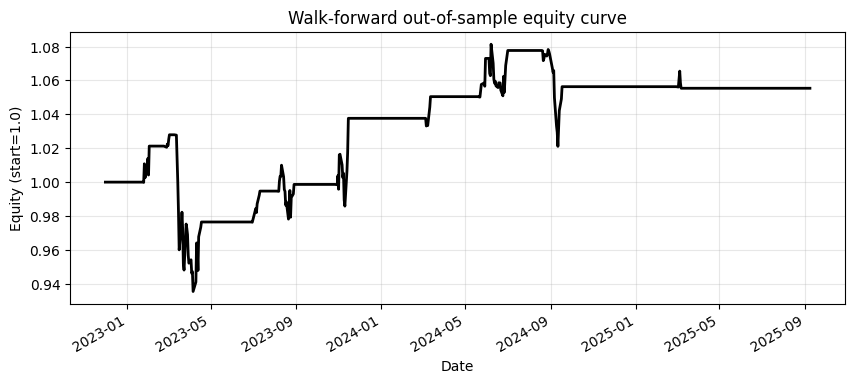

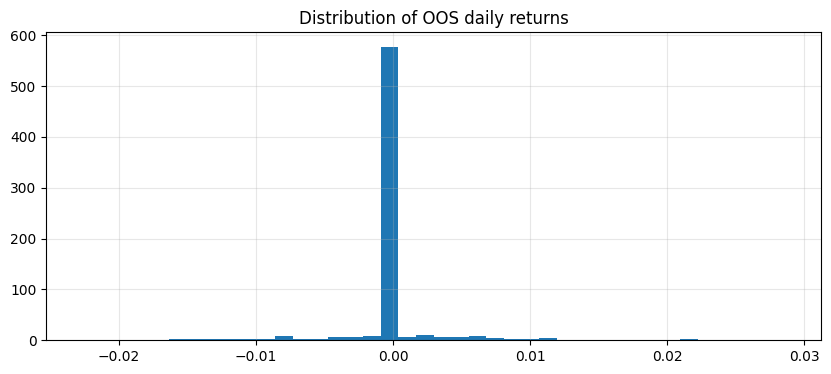

,test_start,test_end,y,x,pvalue,Sharpe,MaxDD,TotalReturn
0,2022-12-01,2023-03-03,MSFT,NVDA,0.009531,2.194268,-0.009594,0.027947
1,2023-03-06,2023-06-02,MSFT,BAC,0.129426,-1.452658,-0.090002,-0.050085
2,2023-06-05,2023-09-01,AAPL,NVDA,0.072713,1.427295,-0.031518,0.022714
3,2023-09-05,2023-12-01,AMZN,TSLA,0.045850,1.854092,-0.030143,0.039081
4,2023-12-04,2024-03-05,KO,WMT,0.005332,NaN,0.000000,0.000000
5,2024-03-06,2024-06-04,MSFT,META,0.047383,3.295044,-0.001816,0.034080
6,2024-06-05,2024-09-04,JPM,WMT,0.018836,-0.427298,-0.028178,-0.007610
7,2024-09-05,2024-12-03,GOOGL,NVDA,0.032972,-0.518358,-0.041982,-0.007999
8,2024-12-04,2025-03-07,AMZN,META,0.016677,-0.176541,-0.009494,-0.000885
9,2025-03-10,2025-06-06,AMZN,BAC,0.000352,NaN,0.000000,0.000000


In [10]:
# Diagnostics plots

if plt is not None:
    oos_equity = (1.0 + oos_rets.fillna(0.0)).cumprod()

    fig, ax = plt.subplots(1, 1)
    oos_equity.plot(ax=ax, color="black", lw=2)
    ax.set_title("Walk-forward out-of-sample equity curve")
    ax.set_ylabel("Equity (start=1.0)")
    ax.grid(True, alpha=0.3)
    plt.show()

    fig, ax = plt.subplots(1, 1)
    oos_rets.hist(bins=40, ax=ax)
    ax.set_title("Distribution of OOS daily returns")
    ax.grid(True, alpha=0.3)
    plt.show()

window_table[["test_start", "test_end", "y", "x", "pvalue", "Sharpe", "MaxDD", "TotalReturn"]]


In [11]:
# Sanity checks: data coverage + how active the strategy is
print("Price rows:", len(prices))
print("Date range:", prices.index.min().date(), "->", prices.index.max().date())
print("Tickers with data:", prices.columns.tolist())

# Activity diagnostics for OOS stitched returns
if len(oos_rets):
    oos_equity = (1.0 + oos_rets.fillna(0.0)).cumprod()
    print("OOS windows:", len(window_table), " | OOS days:", len(oos_rets))
    print("OOS total return:", float(oos_equity.iloc[-1] - 1.0))

# For the last window, check how often we were in-position
if len(window_table):
    last = window_table.iloc[-1]
    train_idx = prices.loc[last["train_start"]: last["train_end"]].index
    test_idx = prices.loc[last["test_start"]: last["test_end"]].index
    combined = prices.loc[train_idx.union(test_idx)]

    bt_last = backtest_pair(
        combined,
        y_ticker=last["y"],
        x_ticker=last["x"],
        beta=float(last["beta"]),
        entry_z=cfg.entry_z,
        exit_z=cfg.exit_z,
        stop_z=cfg.stop_z,
        lookback=60,
        gross_leverage=cfg.gross_leverage,
        max_position_per_leg=cfg.max_position_per_leg,
        cost_bps_per_turnover=cfg.cost_bps_per_turnover,
    ).loc[test_idx]

    in_pos = (bt_last["wy"].abs() + bt_last["wx"].abs()) > 0
    print("Last-window % days in position:", float(in_pos.mean()))
    print("Last-window avg daily turnover:", float(bt_last["turnover"].mean()))


Price rows: 1255
Date range: 2020-12-01 -> 2025-11-28
Tickers with data: ['AAPL', 'AMZN', 'BAC', 'CVX', 'GOOGL', 'JPM', 'KO', 'META', 'MSFT', 'NVDA', 'PEP', 'TSLA', 'WMT', 'XOM']
OOS windows: 11  | OOS days: 693
OOS total return: 0.055414985178306564
Last-window % days in position: 0.0
Last-window avg daily turnover: 0.0


## Robustness Check: Small Parameter Sweep
A good junior-quant writeup doesn’t just show *one* backtest. It shows:
- A clearly defined evaluation protocol (we used walk-forward)
- Sensitivity to a few key parameters (entry/exit thresholds, z-lookback)

We’ll run a small grid and compare out-of-sample metrics. This isn’t “hyper-optimization”; it’s a sanity check.

In [12]:
def run_oos_with_params(
    cfg: ResearchConfig,
    prices: pd.DataFrame,
    entry_z: float,
    exit_z: float,
    lookback: int,
) -> pd.Series:
    cfg2 = replace(cfg, entry_z=entry_z, exit_z=exit_z, z_lookback=lookback)
    oos_rets, _ = walk_forward_pairs(prices, cfg2, lookback=cfg2.z_lookback)
    return summarize_performance(oos_rets)


grid_entry = [1.5, 2.0, 2.5]
grid_exit = [0.25, 0.5, 1.0]
grid_lookback = [40, 60, 90]

rows = []
for lookback in grid_lookback:
    for entry in grid_entry:
        for exit_ in grid_exit:
            # keep exit < entry for a meaningful hysteresis
            if exit_ >= entry:
                continue
            perf = run_oos_with_params(cfg, prices, entry_z=entry, exit_z=exit_, lookback=lookback)
            rows.append({"lookback": lookback, "entry_z": entry, "exit_z": exit_, **perf.to_dict()})

sweep = pd.DataFrame(rows).sort_values(["Sharpe", "CAGR"], ascending=False).reset_index(drop=True)

print("Top parameter settings (OOS):")
display(sweep.head(10))

print("Worst parameter settings (OOS):")
display(sweep.tail(5))


Top parameter settings (OOS):


,lookback,entry_z,exit_z,CAGR,AnnVol,Sharpe,MaxDD,TotalReturn,Days
0,40,1.5,0.50,0.053889,0.112651,0.522404,-0.186491,0.155275,693.0
1,40,1.5,1.00,0.035863,0.099029,0.405409,-0.179095,0.101746,693.0
2,60,2.5,1.00,0.019806,0.062115,0.346741,-0.090002,0.055415,693.0
3,60,2.0,1.00,0.022801,0.075199,0.337402,-0.122497,0.063961,693.0
4,40,2.0,0.50,0.028161,0.096853,0.335269,-0.144723,0.079365,693.0
5,90,1.5,1.00,0.020207,0.099062,0.251725,-0.219113,0.056558,693.0
6,90,1.5,0.50,0.016289,0.111390,0.200913,-0.208674,0.045435,693.0
7,40,1.5,0.25,0.012458,0.121317,0.162819,-0.188270,0.034634,693.0
8,40,2.0,0.25,0.011085,0.108659,0.155862,-0.142049,0.030781,693.0
9,60,1.5,0.50,0.005924,0.113716,0.108935,-0.217368,0.016376,693.0


Worst parameter settings (OOS):


,lookback,entry_z,exit_z,CAGR,AnnVol,Sharpe,MaxDD,TotalReturn,Days
22,90,2.5,0.50,-0.034202,0.080327,-0.392874,-0.162154,-0.091264,693.0
23,40,2.5,1.00,-0.029818,0.062332,-0.454512,-0.112383,-0.079877,693.0
24,90,2.5,1.00,-0.044976,0.074790,-0.577689,-0.162154,-0.118872,693.0
25,90,2.0,0.25,-0.077135,0.105244,-0.709767,-0.257805,-0.198082,693.0
26,90,2.5,0.25,-0.092164,0.095161,-0.967999,-0.284283,-0.233484,693.0
